# Black-Litterman Framework for Portfolio Optimization

[*********************100%%**********************]  10 of 10 completed


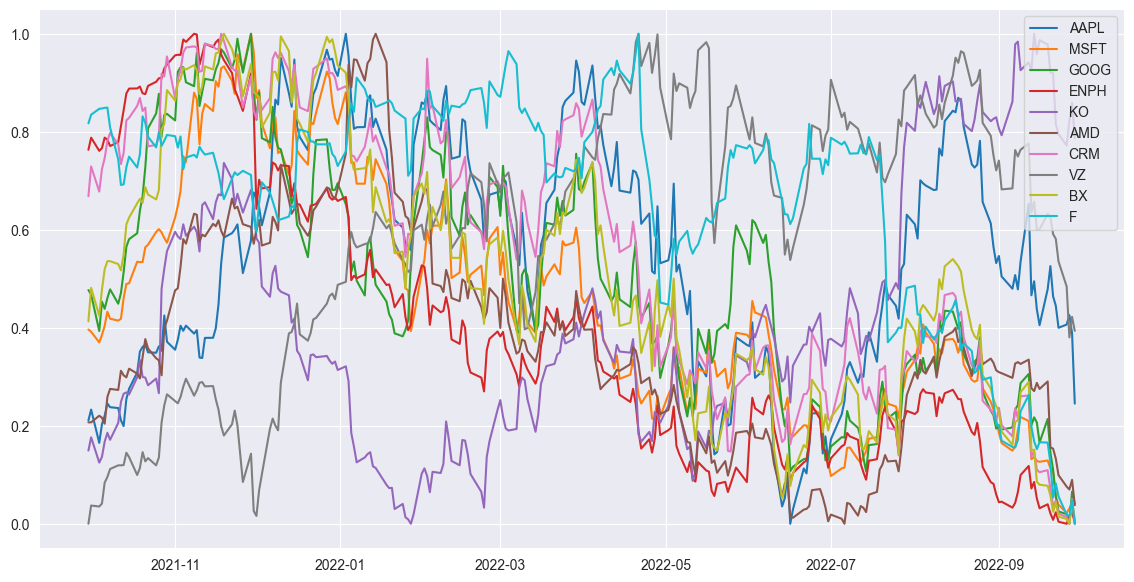

In [2]:
import yfinance as yf
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt

# List of stock tickers
tickers = ['AAPL', 'MSFT', 'GOOG', 'ENPH', 'KO', 'AMD', 'CRM', 'VZ', 'BX', 'F']

# Download historical data for the selected tickers
data = yf.download(tickers, start="2021-09-30", end="2022-09-30")['Adj Close']

# Normalize the data
scaler = MinMaxScaler()
data_normalized = scaler.fit_transform(data)

# Convert normalized data back to a DataFrame
data_normalized = pd.DataFrame(data_normalized, columns=tickers, index=data.index)

# Split the data into training and testing sets
train_size = int(len(data_normalized) * 0.8)
train_data = data_normalized[:train_size]
test_data = data_normalized[train_size:]

# Plot the normalized data
plt.figure(figsize=(14, 7))
for col in data_normalized.columns:
    plt.plot(data_normalized.index, data_normalized[col], label=col)
plt.legend()
plt.show()


## Analysis:
Lets perform some analysis and print some graphs for better interpritation of the data.

              Open         High          Low        Close        Volume  \
count  2517.000000  2517.000000  2517.000000  2517.000000  2.517000e+03   
mean   3155.421607  3172.274634  3137.319737  3155.991458  3.977656e+09   
std     966.403706   972.010760   960.835950   966.860570  9.595210e+08   
min    1833.400024  1847.000000  1810.099976  1829.079956  1.296530e+09   
25%    2253.770020  2263.790039  2248.439941  2253.280029  3.393060e+09   
50%    2885.830078  2894.830078  2869.590088  2884.050049  3.801250e+09   
75%    4055.149902  4082.610107  4033.929932  4067.360107  4.327390e+09   
max    5476.149902  5490.379883  5471.319824  5487.029785  9.976520e+09   

       Dividends  Stock Splits  
count     2517.0        2517.0  
mean         0.0           0.0  
std          0.0           0.0  
min          0.0           0.0  
25%          0.0           0.0  
50%          0.0           0.0  
75%          0.0           0.0  
max          0.0           0.0  
Statistics=0.918, p=0.000
S

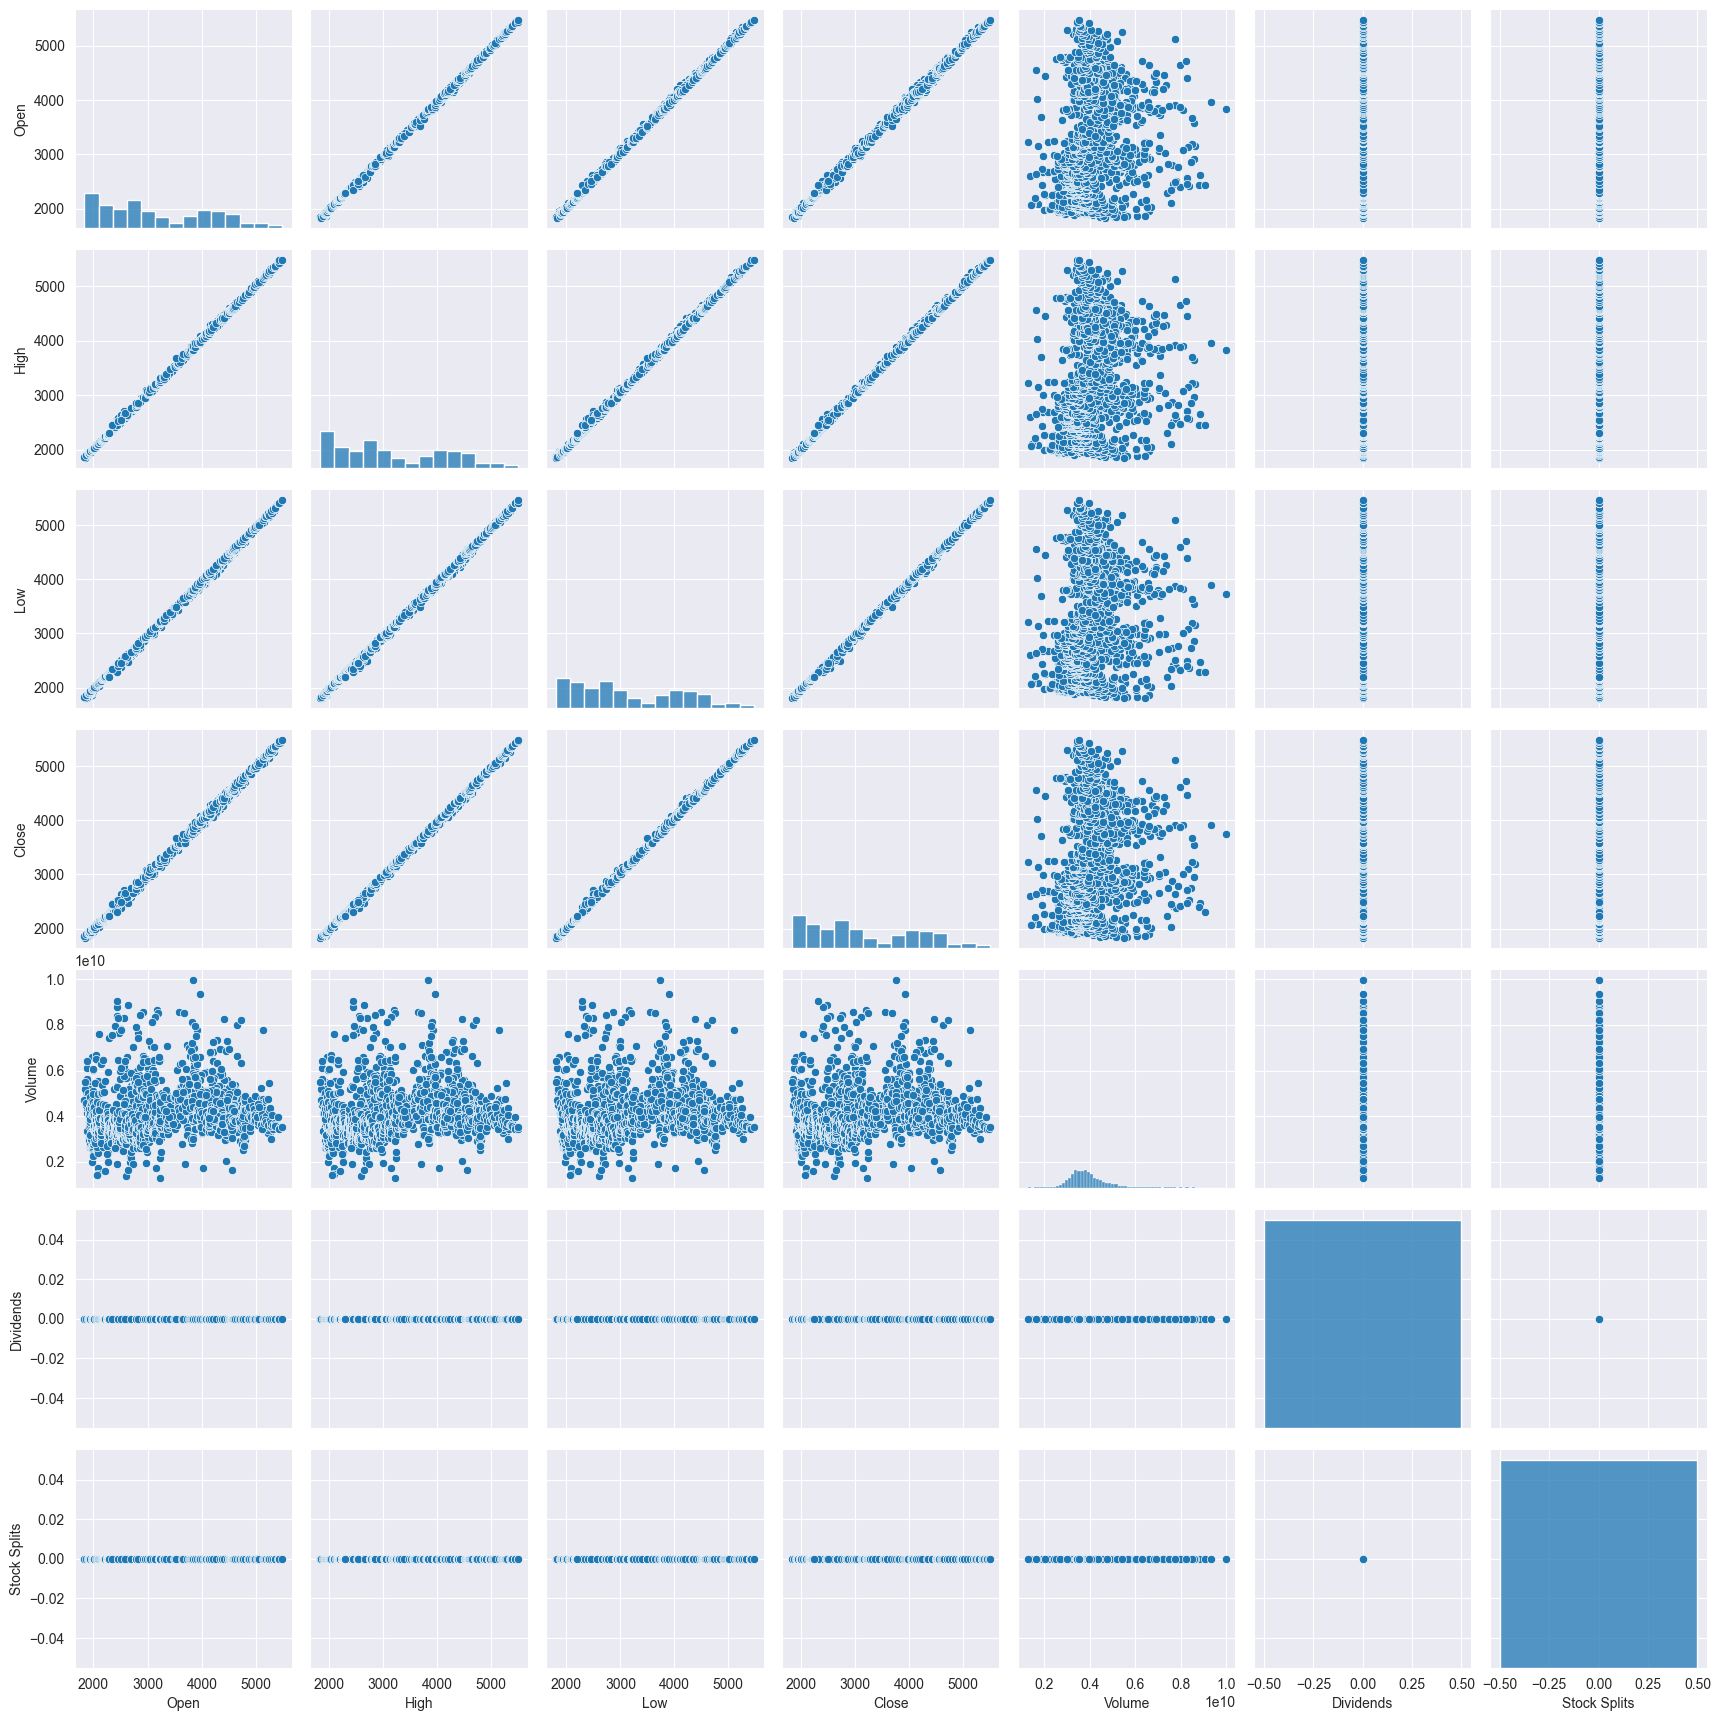

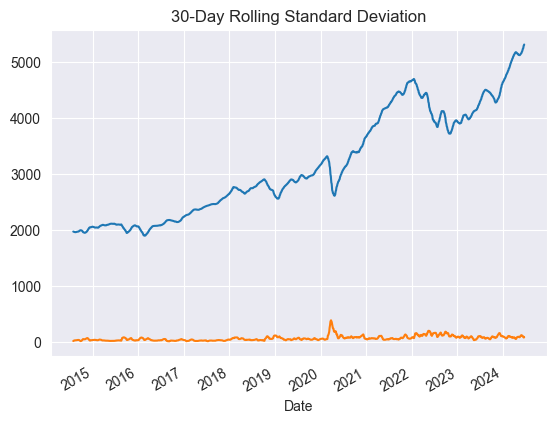

In [3]:
import pandas as pd
import yfinance as yf
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import shapiro, spearmanr, wilcoxon

# Load data
sp500 = yf.Ticker("^GSPC")
data = sp500.history(period="10y")

# Summary statistics
print(data.describe())

# Data normality test (Shapiro-Wilk Test)
stat, p = shapiro(data['Close'])
print('Statistics=%.3f, p=%.3f' % (stat, p))

# Spearman correlation test
corr, _ = spearmanr(data['Open'], data['Close'])
print('Spearman correlation: %.3f' % corr)

# Visualization
sns.pairplot(data)
plt.show()

# Rolling statistics
data['Close'].rolling(window=30).mean().plot(title='30-Day Moving Average')     # Trend measure (moving average)
data['Close'].rolling(window=30).std().plot(title='30-Day Rolling Standard Deviation')      # Volatility measure (standard deviation) 
plt.show()


# Implementation:

Firstly we implement Transformer, Generator, and Discriminator for our model.

1. Transfomer:
    
This class defines a neural network model using the Transformer architecture for time series or sequential data processing. The model includes a transformer and a fully connected (linear) layer.

2. Generator:

The Generator class defines the generator part of the GAN, responsible for creating fake data that resembles the real data. This class uses a simple feedforward neural network with three layers. The generator produces fake data, and the discriminator evaluates the data (real or fake). The training loop alternates between training the discriminator and the generator to improve their performance iteratively.

3. Discriminator:

The Discriminator class in a GAN (Generative Adversarial Network) is responsible for distinguishing between real and fake data. It acts as a binary classifier that assigns probabilities to input data indicating whether they are real (from the training data) or fake (generated by the generator).


In [4]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset

# Transformer model - for time series data
class TransformerModel(nn.Module):   
    def __init__(self, input_dim, model_dim, num_heads, num_layers, output_dim):
        super(TransformerModel, self).__init__()
        self.transformer = nn.Transformer(d_model=model_dim, nhead=num_heads, num_encoder_layers=num_layers)
        self.fc = nn.Linear(model_dim, output_dim)
    
    def forward(self, x):
        x = self.transformer(x)
        x = self.fc(x)
        return x

# GAN models - Generator and Discriminator
class Generator(nn.Module):
    def __init__(self, input_dim, output_dim):
        super(Generator, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(input_dim, 128),
            nn.ReLU(),
            nn.Linear(128, output_dim),
            nn.Tanh()
        )
    
    def forward(self, x):
        return self.model(x)

# Discriminator model - binary classifier (real or fake) 
class Discriminator(nn.Module):
    def __init__(self, input_dim):
        super(Discriminator, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(input_dim, 128),
            nn.ReLU(),
            nn.Linear(128, 1),
            nn.Sigmoid()
        )
    
    def forward(self, x):
        return self.model(x)

# Parameters
input_dim = len(tickers)
model_dim = 64
num_heads = 4
num_layers = 2
output_dim = len(tickers)

# Initialize models
transformer = TransformerModel(input_dim, model_dim, num_heads, num_layers, output_dim)     # Transformer model for time series data
generator = Generator(input_dim, output_dim)    # Generator model for GAN with feedforward neural network
discriminator = Discriminator(output_dim)       # Discriminator model for GAN with feedforward neural network

# Loss and optimizers 
# it takes the output of the generator and the real data and compares them to the real labels (1 for real data and 0 for fake data).
criterion = nn.BCELoss()
optimizer_g = optim.Adam(generator.parameters(), lr=0.001)
optimizer_d = optim.Adam(discriminator.parameters(), lr=0.001)

# Training loop for GAN
num_epochs = 100
for epoch in range(num_epochs):
    for real_data in DataLoader(TensorDataset(torch.tensor(train_data.values, dtype=torch.float32)), batch_size=32, shuffle=True):
        real_data = real_data[0]
        batch_size = real_data.size(0)

        # Train Discriminator
        noise = torch.randn(batch_size, input_dim)
        fake_data = generator(noise)
        real_labels = torch.ones(batch_size, 1)
        fake_labels = torch.zeros(batch_size, 1)

        optimizer_d.zero_grad()
        outputs = discriminator(real_data)
        real_loss = criterion(outputs, real_labels)
        outputs = discriminator(fake_data.detach())
        fake_loss = criterion(outputs, fake_labels)
        d_loss = real_loss + fake_loss
        d_loss.backward()
        optimizer_d.step()

        # Train Generator
        optimizer_g.zero_grad()
        outputs = discriminator(fake_data)
        g_loss = criterion(outputs, real_labels)
        g_loss.backward()
        optimizer_g.step()

    print(f'Epoch [{epoch+1}/{num_epochs}] - D Loss: {d_loss.item():.4f}, G Loss: {g_loss.item():.4f}')


C:\Python_Interpriters\Power_Champian\lib\site-packages\torch\nn\modules\transformer.py:306: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")


Epoch [1/100] - D Loss: 1.2825, G Loss: 0.7149
Epoch [2/100] - D Loss: 1.2891, G Loss: 0.6372
Epoch [3/100] - D Loss: 1.2377, G Loss: 0.6131
Epoch [4/100] - D Loss: 1.1778, G Loss: 0.5926
Epoch [5/100] - D Loss: 1.2709, G Loss: 0.5383
Epoch [6/100] - D Loss: 1.3735, G Loss: 0.5141
Epoch [7/100] - D Loss: 1.3878, G Loss: 0.5294
Epoch [8/100] - D Loss: 1.3627, G Loss: 0.6163
Epoch [9/100] - D Loss: 1.4100, G Loss: 0.6782
Epoch [10/100] - D Loss: 1.3130, G Loss: 0.8143
Epoch [11/100] - D Loss: 1.3499, G Loss: 0.9626
Epoch [12/100] - D Loss: 1.3885, G Loss: 1.0023
Epoch [13/100] - D Loss: 1.3114, G Loss: 0.9946
Epoch [14/100] - D Loss: 1.4601, G Loss: 0.8664
Epoch [15/100] - D Loss: 1.6418, G Loss: 0.7966
Epoch [16/100] - D Loss: 1.4765, G Loss: 0.7189
Epoch [17/100] - D Loss: 1.4837, G Loss: 0.7008
Epoch [18/100] - D Loss: 1.4627, G Loss: 0.6476
Epoch [19/100] - D Loss: 1.3787, G Loss: 0.6635
Epoch [20/100] - D Loss: 1.3589, G Loss: 0.6440
Epoch [21/100] - D Loss: 1.2995, G Loss: 0.7114
E

In [12]:
# show architecture of the model 
print(transformer)
print(generator)
print(discriminator)


TransformerModel(
  (transformer): Transformer(
    (encoder): TransformerEncoder(
      (layers): ModuleList(
        (0-1): 2 x TransformerEncoderLayer(
          (self_attn): MultiheadAttention(
            (out_proj): NonDynamicallyQuantizableLinear(in_features=64, out_features=64, bias=True)
          )
          (linear1): Linear(in_features=64, out_features=2048, bias=True)
          (dropout): Dropout(p=0.1, inplace=False)
          (linear2): Linear(in_features=2048, out_features=64, bias=True)
          (norm1): LayerNorm((64,), eps=1e-05, elementwise_affine=True)
          (norm2): LayerNorm((64,), eps=1e-05, elementwise_affine=True)
          (dropout1): Dropout(p=0.1, inplace=False)
          (dropout2): Dropout(p=0.1, inplace=False)
        )
      )
      (norm): LayerNorm((64,), eps=1e-05, elementwise_affine=True)
    )
    (decoder): TransformerDecoder(
      (layers): ModuleList(
        (0-5): 6 x TransformerDecoderLayer(
          (self_attn): MultiheadAttention(
  

## Black-Litterman Framework:

The Black-Litterman model is an asset allocation model that combines the expected returns from the equilibrium market with the views of an investor to generate an optimal portfolio. The model uses the market equilibrium returns, investor views, and uncertainty in views to calculate the optimal portfolio weights. The Black-Litterman model is widely used in portfolio optimization to incorporate investor views and market equilibrium returns into the asset allocation process.

The Black-Litterman model consists of the following steps:

1. Calculate the implied equilibrium returns based on the market weights and covariance matrix.
2. Generate investor views on the expected returns of assets.
3. Calculate the uncertainty in views (Omega matrix) based on the views.
4. Adjust the covariance matrix based on the uncertainty in views.
5. Calculate the Black-Litterman expected returns based on the adjusted covariance matrix and investor views.
6. Optimize the portfolio weights to maximize the Sharpe ratio.
7. Compare the optimized portfolio with an equally weighted portfolio.

The Black-Litterman expected returns formula is:

![Black-Litterman Expected Returns](https://media.fe.training/2024/02/hgpjwmpr-Exepected-Returns-Image-2.png)

![Black-Litterman Expected Returns Formula](https://media.fe.training/2024/02/pqm0bt20-Expected-return-formula-Image-4.png)


In [6]:
# Black-Litterman parameters
'''
A δ value of 2.5 indicates that the investor is willing to take on a risk level corresponding to a standard deviation of approximately 15.5% in the market returns. This means the investor is moderately risk-averse but still willing to accept a fair amount of market risk for the potential of higher returns.'''
delta = 2.5 # risk aversion rate -> low means high risk appetite and vice-versa || equation delta =( expected return of PO - risk free rate) 
tau = 0.05 # uncertainty in views (tau = 1 / confidence level) -> low means more confidence in views || equation tau = 1 / confidence level
risk_free_rate = 0.02 # risk-free rate of return

# Calculate the implied equilibrium returns (Π)
cov_matrix = train_data.cov()
market_weights = np.ones(len(tickers)) / len(tickers)   # Assuming equal weights for all assets
pi = delta * np.dot(cov_matrix, market_weights)  # Expected returns based on market weights (Implied equilibrium returns)

# Generate views using the Transformer-GAN model
views = generator(torch.randn(len(tickers), input_dim)).detach().numpy()    # Generate views using the generator model (fake data) 

# Calculate the Omega matrix (uncertainty in views)
P = np.eye(len(tickers))    # Identity matrix (views are on the returns of individual assets)
Q = views.mean(axis=0)    # Average of the generated views
omega = np.diag(np.diag(np.dot(np.dot(P, tau * cov_matrix), P.T)))  # Uncertainty matrix (Omega) based on views

# Adjusted covariance matrix (Σ̂)
adjusted_cov_matrix = cov_matrix + np.linalg.inv(np.linalg.inv(tau * cov_matrix) + np.dot(np.dot(P.T, np.linalg.inv(omega)), P))

# Black-Litterman expected returns (µBL)
mu_bl = np.dot(np.linalg.inv(np.linalg.inv(tau * cov_matrix) + np.dot(np.dot(P.T, np.linalg.inv(omega)), P)), 
               np.dot(np.linalg.inv(tau * cov_matrix), pi) + np.dot(np.dot(P.T, np.linalg.inv(omega)), Q))

# Portfolio optimization (maximizing Sharpe Ratio)
def objective(weights):
    return - (np.dot(weights, mu_bl) - risk_free_rate) / np.sqrt(np.dot(np.dot(weights, adjusted_cov_matrix), weights.T))

constraints = ({'type': 'eq', 'fun': lambda weights: np.sum(weights) - 1})
bounds = [(0, 1) for _ in range(len(tickers))]
initial_guess = market_weights

from scipy.optimize import minimize
result = minimize(objective, initial_guess, bounds=bounds, constraints=constraints)
optimal_weights = result.x

print('Optimal Portfolio Weights:', optimal_weights)


Optimal Portfolio Weights: [0.00000000e+00 1.01684877e-02 8.84413505e-02 1.98197959e-02
 1.16724525e-01 9.56000216e-18 1.64643591e-17 9.67383076e-02
 2.27447185e-02 6.45362815e-01]


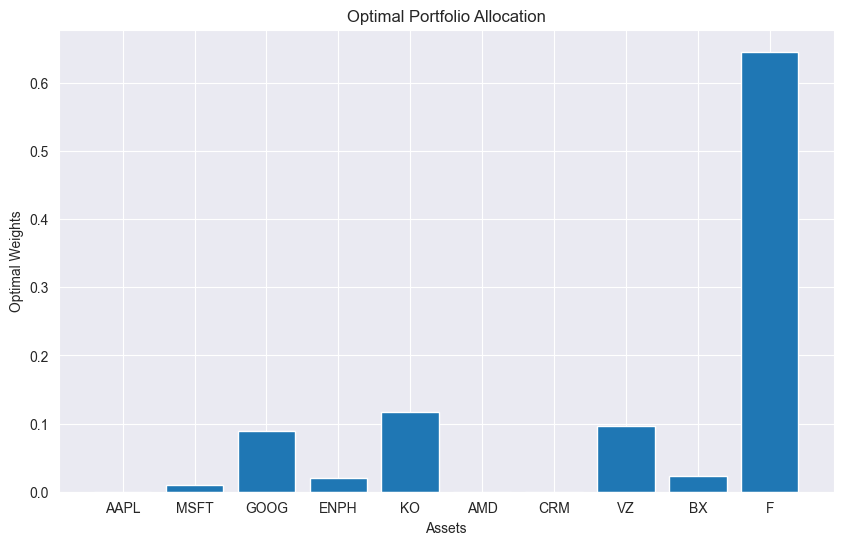

In [7]:
import matplotlib.pyplot as plt

# Plot the optimal weights
plt.figure(figsize=(10, 6))
plt.bar(tickers, optimal_weights)
plt.xlabel('Assets')
plt.ylabel('Optimal Weights')
plt.title('Optimal Portfolio Allocation')
plt.show()


In [8]:
for i in optimal_weights:
    # print 4 decimal places
    print(f'{i:.4f}')
print(optimal_weights.sum())

0.0000
0.0102
0.0884
0.0198
0.1167
0.0000
0.0000
0.0967
0.0227
0.6454
1.0


In [9]:
# Calculate expected return and volatility of the optimized portfolio
expected_return = np.dot(optimal_weights, mu_bl)
portfolio_volatility = np.sqrt(np.dot(np.dot(optimal_weights, adjusted_cov_matrix), optimal_weights.T))
sharpe_ratio = (expected_return - risk_free_rate) / portfolio_volatility

print(f'Expected Return: {expected_return:.4f}')
print(f'Portfolio Volatility: {portfolio_volatility:.4f}')
print(f'Sharpe Ratio: {sharpe_ratio:.4f}')


Expected Return: 0.3452
Portfolio Volatility: 0.0729
Sharpe Ratio: 4.4604



Benchmark (Equally Weighted Portfolio):
Expected Return: 0.3711
Portfolio Volatility: 0.1459
Sharpe Ratio: 2.4065


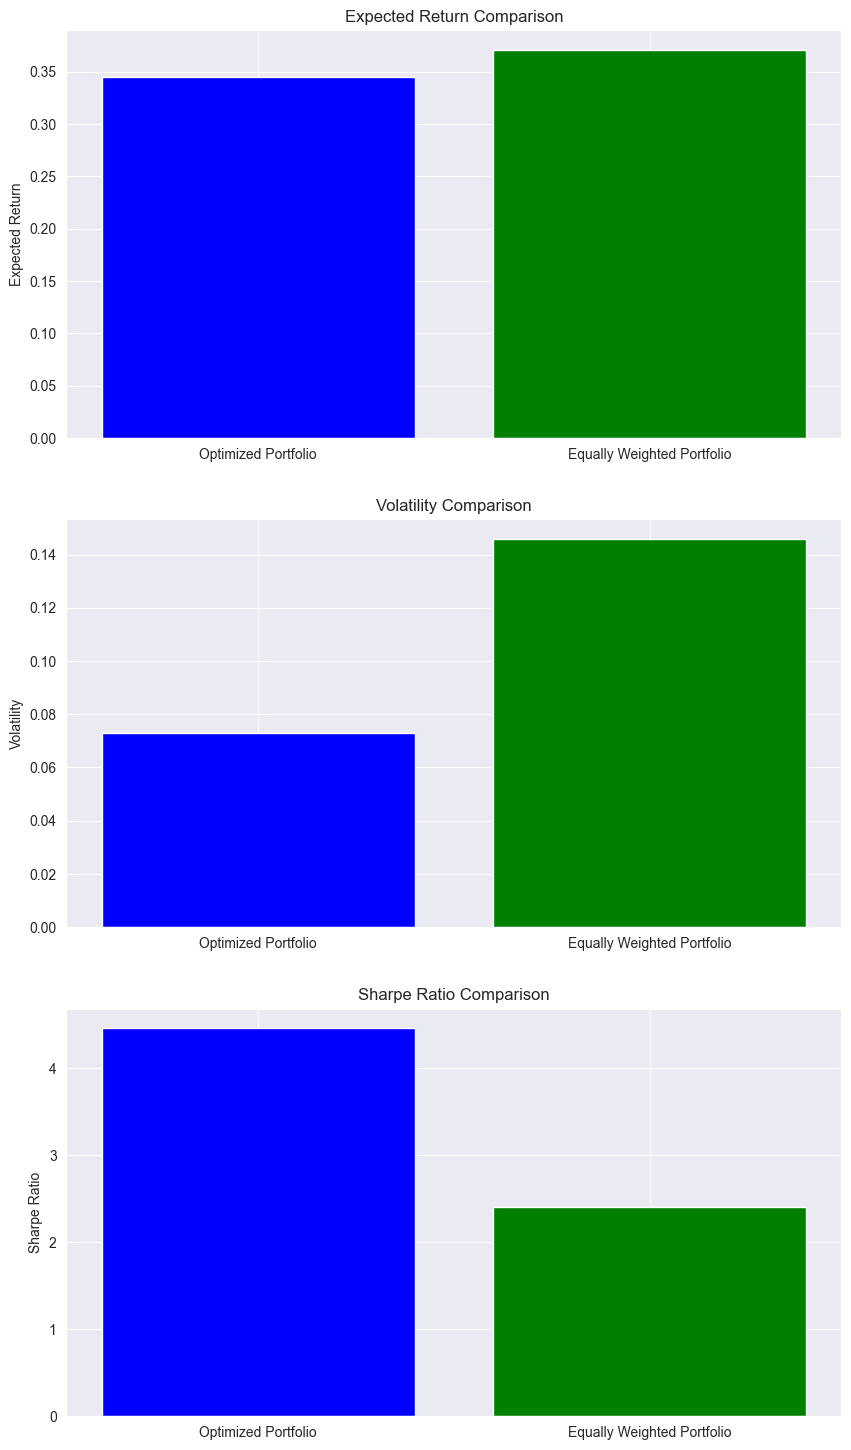

In [10]:
# Calculate the performance of an equally weighted portfolio
equal_weights = np.ones(len(tickers)) / len(tickers)
equal_expected_return = np.dot(equal_weights, mu_bl)
equal_portfolio_volatility = np.sqrt(np.dot(np.dot(equal_weights, adjusted_cov_matrix), equal_weights.T))
equal_sharpe_ratio = (equal_expected_return - risk_free_rate) / equal_portfolio_volatility

print('\nBenchmark (Equally Weighted Portfolio):')
print(f'Expected Return: {equal_expected_return:.4f}')
print(f'Portfolio Volatility: {equal_portfolio_volatility:.4f}')
print(f'Sharpe Ratio: {equal_sharpe_ratio:.4f}')

# Comparison bar chart
labels = ['Optimized Portfolio', 'Equally Weighted Portfolio']
returns = [expected_return, equal_expected_return]
volatilities = [portfolio_volatility, equal_portfolio_volatility]
sharpe_ratios = [sharpe_ratio, equal_sharpe_ratio]

x = np.arange(len(labels))

fig, ax = plt.subplots(3, 1, figsize=(10, 18))

# Expected return comparison
ax[0].bar(x, returns, color=['blue', 'green'])
ax[0].set_ylabel('Expected Return')
ax[0].set_title('Expected Return Comparison')
ax[0].set_xticks(x)
ax[0].set_xticklabels(labels)

# Volatility comparison
ax[1].bar(x, volatilities, color=['blue', 'green'])
ax[1].set_ylabel('Volatility')
ax[1].set_title('Volatility Comparison')
ax[1].set_xticks(x)
ax[1].set_xticklabels(labels)

# Sharpe ratio comparison
ax[2].bar(x, sharpe_ratios, color=['blue', 'green'])
ax[2].set_ylabel('Sharpe Ratio')
ax[2].set_title('Sharpe Ratio Comparison')
ax[2].set_xticks(x)
ax[2].set_xticklabels(labels)

plt.show()
